In [55]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import functions as myTSEB

In [56]:
path = rf'files/inputs_sensitivity_analysis_CN_R.csv'

data = pd.read_csv(path)
data.loc[data.outcome>=0, 'error'] = 0
data.loc[data.outcome<0, 'error'] = 1
data.loc[data.outcome==-9999, 'error'] = 2
con = data.outcome.isna()
data.loc[con, 'outome'] = -1
# print(data.head())

In [60]:
K_be = myTSEB.estimate_Kbe(data.x_LAD, 0)
fv02 = np.clip((1 - np.exp(-K_be * data.LAI)) * data.difffv, 0, 1)
data.loc[:, 'fv'] = fv02

data.loc[:, 'Trad'] = data.Tair + data.diffTrad
# print(fv02)

In [91]:
summary = data.groupby("error")[data.columns[1:-2]].quantile([0.1, 0.5, 0.9]).unstack()
summary
# summary.to_csv("quantiles_by_class.csv")

LAI                        difffv                           h_V  \
            0.1       0.5       0.9       0.1       0.5       0.9       0.1   
error                                                                         
0.0    1.148193  3.946045  7.132080  0.738086  0.897461  1.060352  0.523486   
1.0    2.908203  5.608643  7.527588  0.749414  0.914258  1.056445  1.542246   
2.0    5.879639  7.183350  7.798584  0.772070  0.922070  1.058789  1.365674   

                            row_sep  ... rho_nir_soil      outcome  \
            0.5       0.9       0.1  ...          0.9          0.1   
error                                ...                             
0.0    2.375342  4.456885  1.612305  ...     0.464624   140.625587   
1.0    3.212744  4.681787  1.571289  ...     0.469409  -749.080634   
2.0    3.112256  4.854053  1.196289  ...     0.405151 -9999.000000   

                                error           outome          
               0.5          0.9   0.1  0.5  0.9    0.1 0.5 0.9  
error                                                           
0.0     377.147915   580.111945   0.0  0.0  0.0    NaN NaN NaN  
1.0    -148.872046   -20.348422   1.0  1.0  1.0    NaN NaN NaN  
2.0   -9999.000000 -9999.000000   2.0  2.0  2.0    NaN NaN NaN  

[3 rows x 81 columns]

In [110]:
summary2 = summary.T.reset_index()
summary2 = summary2.rename(columns={"level_0": "param", "level_1": "percentile"}).reset_index()
summary2 = summary2[['param', "percentile", 0.0, 1.0, 2.0]]
summary2 = summary2.melt(id_vars=["param", 'percentile'],
        var_name="error",
        value_name="value")
# summary2 = summary2.rename(columns={"index": "class"})
summary2

,param,percentile,error,value
0,LAI,0.1,0.0,1.148193
1,LAI,0.5,0.0,3.946045
2,LAI,0.9,0.0,7.132080
3,difffv,0.1,0.0,0.738086
4,difffv,0.5,0.0,0.897461
...,...,...,...,...
238,error,0.5,2.0,2.000000
239,error,0.9,2.0,2.000000
240,outome,0.1,2.0,NaN
241,outome,0.5,2.0,NaN


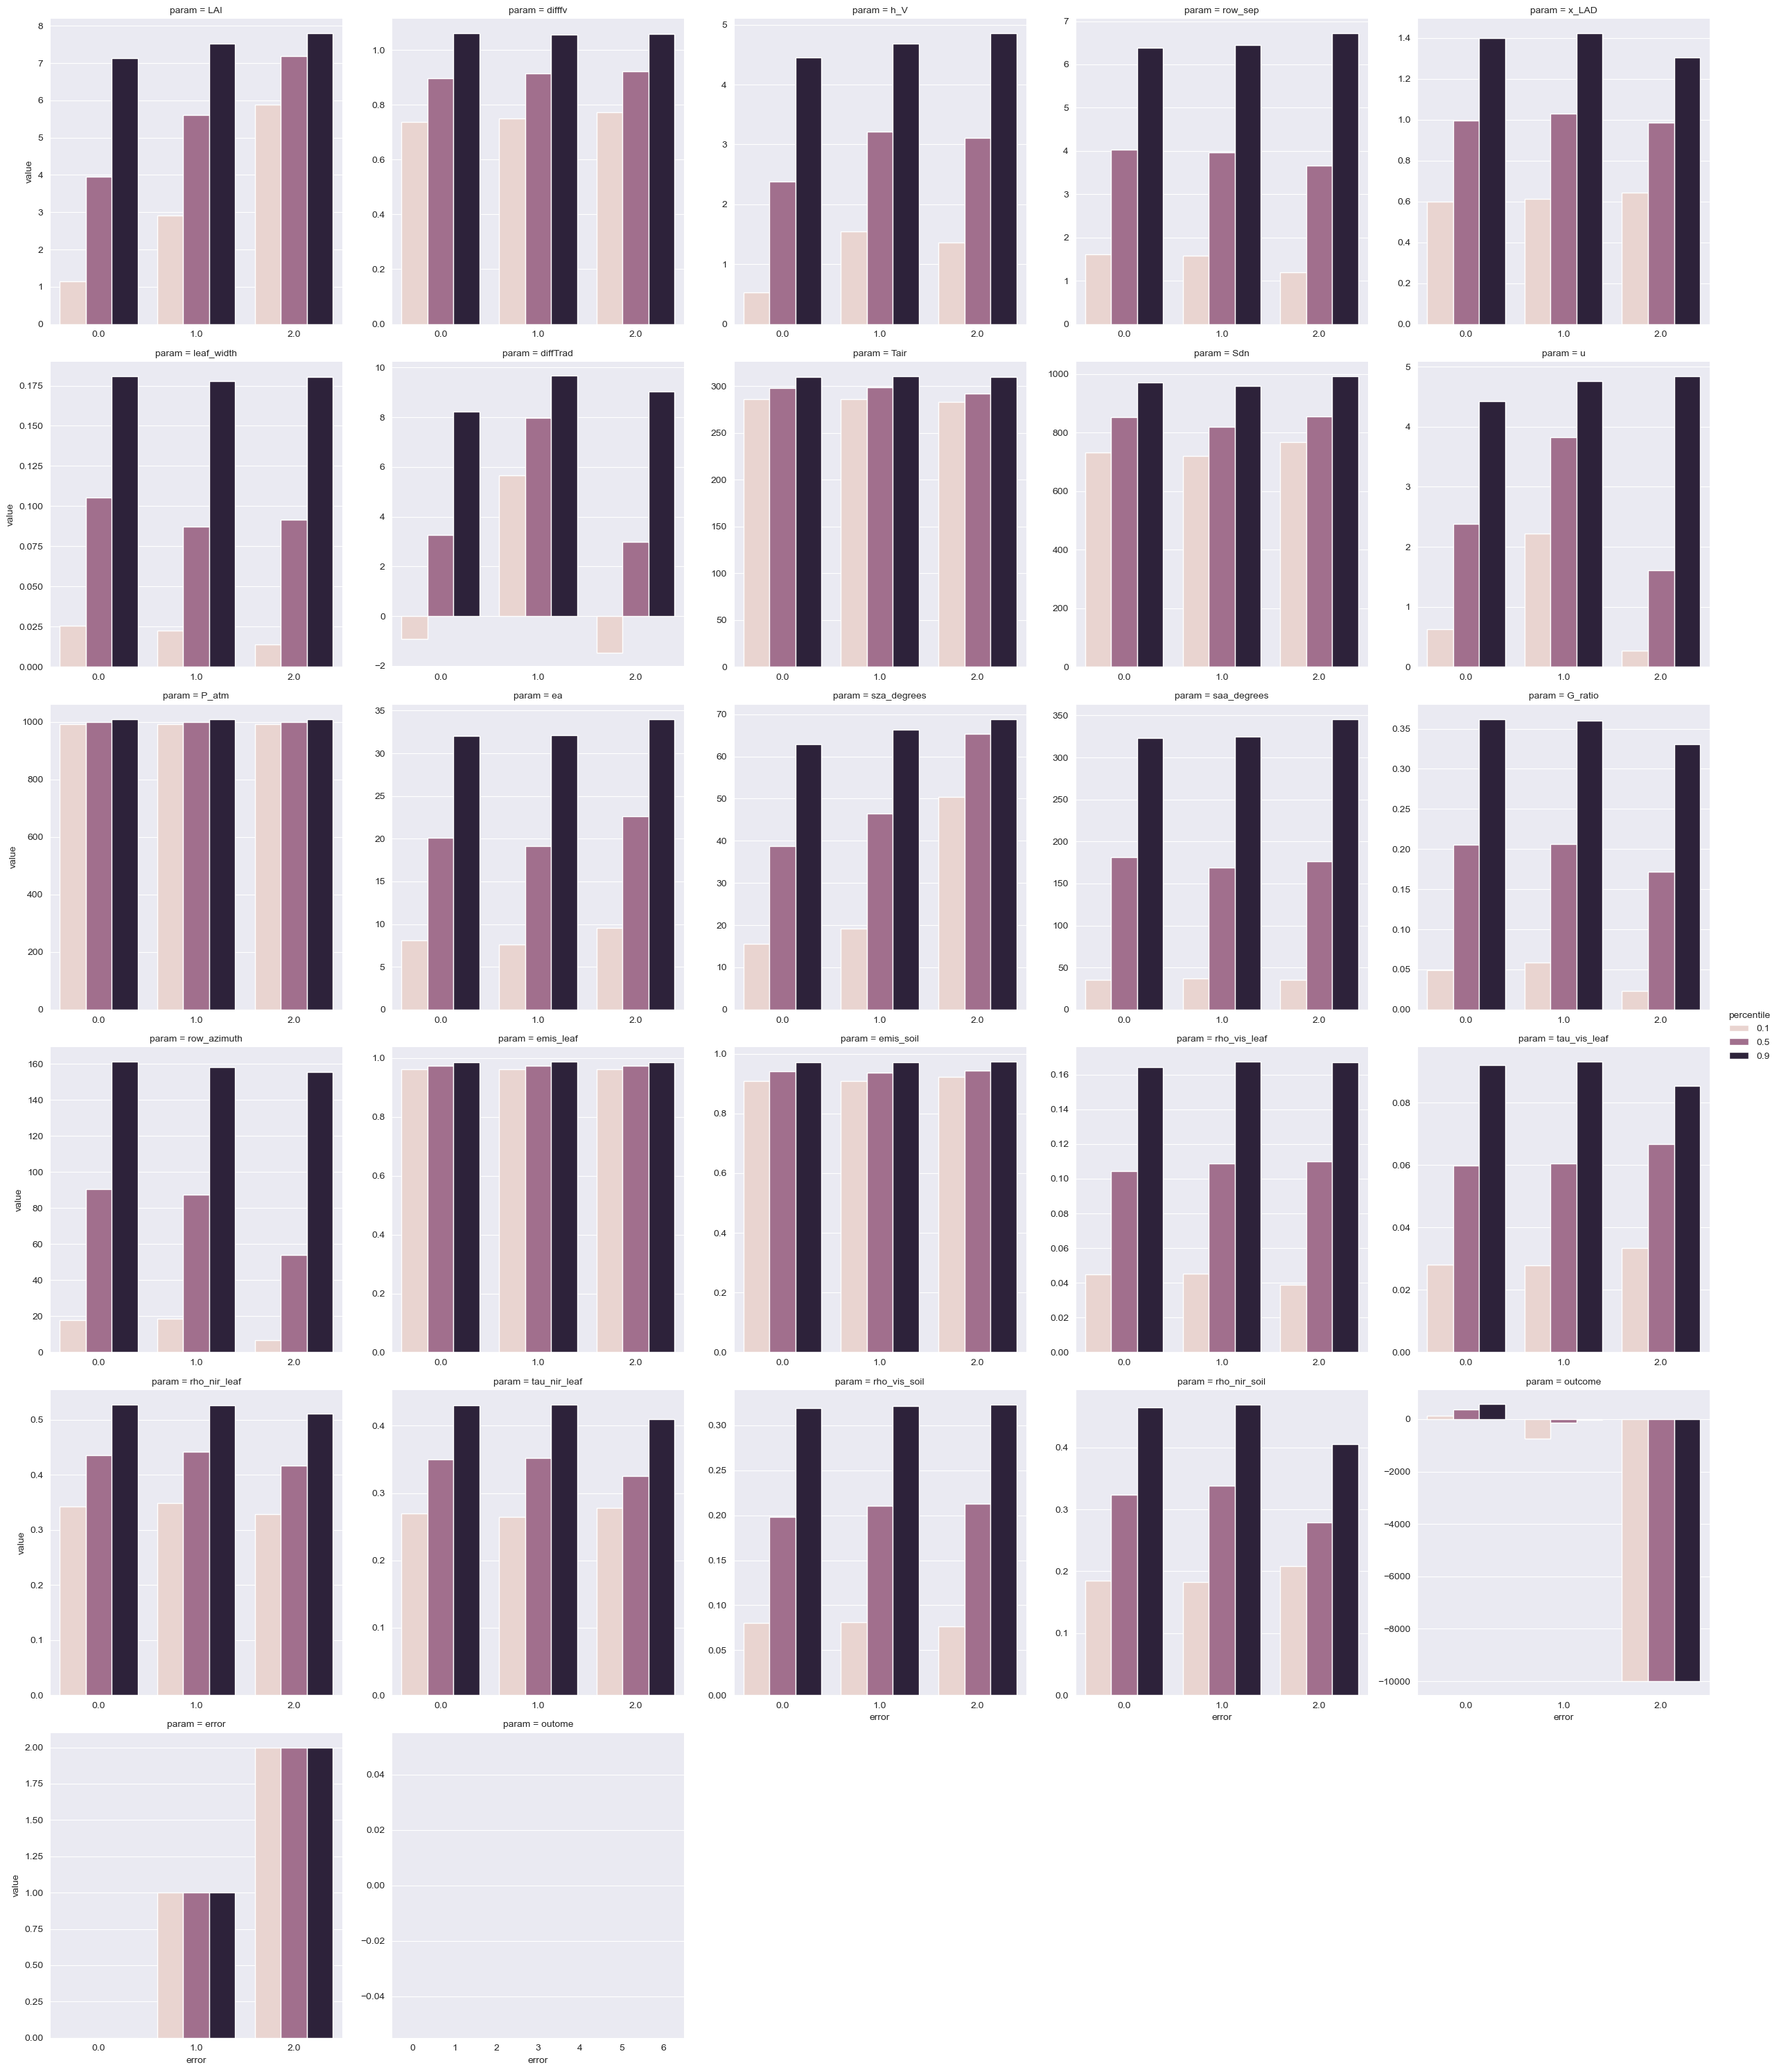

In [113]:
sns.catplot(data=summary2, x='error', y='value', hue='percentile', col='param', kind='bar', col_wrap=5, sharey=False, sharex=False)

In [115]:
data.columns[1:-5]

Index(['LAI', 'difffv', 'h_V', 'row_sep', 'x_LAD', 'leaf_width', 'diffTrad',
       'Tair', 'Sdn', 'u', 'P_atm', 'ea', 'sza_degrees', 'saa_degrees',
       'G_ratio', 'row_azimuth', 'emis_leaf', 'emis_soil', 'rho_vis_leaf',
       'tau_vis_leaf', 'rho_nir_leaf', 'tau_nir_leaf', 'rho_vis_soil',
       'rho_nir_soil'],
      dtype='object')

In [117]:
from sklearn.tree import DecisionTreeClassifier, export_text

names = data.columns[1:-5]
Xfeat = data[names].values
y = data["error"].astype(int).values  # 1 = failure (neg_total or nan)

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=200, random_state=0)
clf.fit(Xfeat, y)

print(export_text(clf, feature_names=names))

|--- diffTrad <= 5.83
|   |--- LAI <= 5.88
|   |   |--- diffTrad <= 5.48
|   |   |   |--- diffTrad <= -1.86
|   |   |   |   |--- class: 0
|   |   |   |--- diffTrad >  -1.86
|   |   |   |   |--- class: 0
|   |   |--- diffTrad >  5.48
|   |   |   |--- rho_vis_leaf <= 0.08
|   |   |   |   |--- class: 0
|   |   |   |--- rho_vis_leaf >  0.08
|   |   |   |   |--- class: 0
|   |--- LAI >  5.88
|   |   |--- sza_degrees <= 66.92
|   |   |   |--- diffTrad <= 4.19
|   |   |   |   |--- class: 0
|   |   |   |--- diffTrad >  4.19
|   |   |   |   |--- class: 0
|   |   |--- sza_degrees >  66.92
|   |   |   |--- class: 2
|--- diffTrad >  5.83
|   |--- u <= 3.09
|   |   |--- LAI <= 6.02
|   |   |   |--- u <= 2.08
|   |   |   |   |--- class: 0
|   |   |   |--- u >  2.08
|   |   |   |   |--- class: 0
|   |   |--- LAI >  6.02
|   |   |   |--- u <= 1.24
|   |   |   |   |--- class: 0
|   |   |   |--- u >  1.24
|   |   |   |   |--- class: 1
|   |--- u >  3.09
|   |   |--- LAI <= 2.65
|   |   |   |--- h_V <= 3

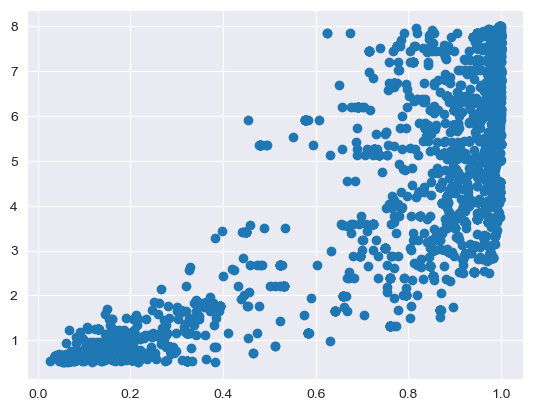

In [25]:
plt.scatter(data=data_eq0, x="f_theta", y='LAI')